# Auto-encodeur Convolutif et traitement d'images (CNNs)

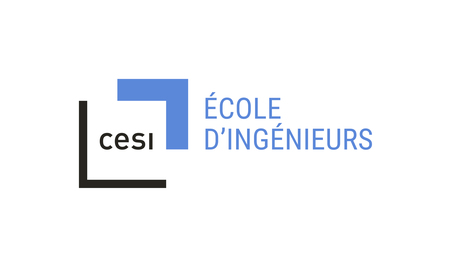


Les auto-encodeurs ont été largement appliqués dans la réduction de dimension, on l'a vu dans le Workshop précédent. Ici, on va voir son utilisation pour la réduction du bruit d'image. Et on verra que les opérations de convolutions qu'on avait utilisées l'année dernière pour faire du denoising seront de nouveau utilisées.

# 1. Traitement d'images

## 1.1 Auto-encodeur convolutif

Pour modéliser les données d'image, on utilise les réseaux de neurones convolutifs (CNN ou ConvNet).<br>
Comme évoqué dans les précédents WS, une image en noir et blanc est *ensemble de pixels, où chaque pixel est représenté par un nombre compris entre 0 et 255.*

Vous avez déjà vu l'année dernière les opérations de convolution pour manipuler des images (et même faire du débruitage). Mais ici, on va utiliser ces opérations de convolution dans un réseau de neurones. Plus précisément, on va utiliser un auto-encodeur. Les auto-encodeurs ont été largement appliqués dans la réduction de dimension (et vous l'avez vu), mais aussi pour la réduction du bruit d'image, notamment en utilisant des opérations de convolution. On peut alors parler d'auto-encodeur convolutifs. Pourquoi les auto-encodeurs convolutifs sont adaptés aux données de type images ?

<blockquote>Tout simplement parce qu’une image contient beaucoup, mais alors beaucoup de données en entrée. Imaginez avec une petite image de 100×100 pixels en couleurs … delà nous fait déjà 100x100x3 donc 30 000 données à envoyer dans le réseau de neurones (et c’est une petite image!). Si vous commencez à empiler couches et neurones, très vite le nombre de paramètres de votre réseau va exploser et le nombre de calculs va croitre de manière exponentielle … de quoi mettre par terre votre machine !

Il fallait donc trouver une autre approche que celle classique des réseaux ANN (ou Perceptron Multicouches). L’idée derrière les filtres a convolution est qu’ils permettent de trouver des patterns, des formes dans les images (rappelez vous l’article précédent qui permettait de trouver les contours par exemple). Les CNN permettent en effet de déterminer de manière progressive les différentes formes puis de les assembler pour en trouver d’autres.

L’exemple classique est que les premières couches d’un tel réseau trouve les formes de base d’un visage: les traits principaux, puis on va détecteur les premières formes: nez, bouche, yeux, etc., puis pour finir le visage et pourquoi par reconnaître la personne, etc.
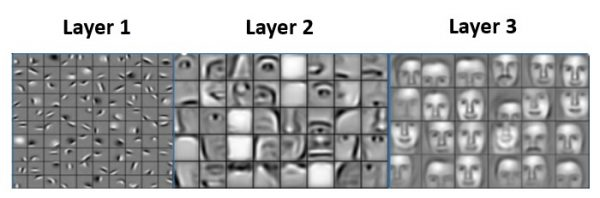
</blockquote>

Finalement, un auto-encodeur convolutif n'est qu'une variante de CNN. Vous vous souvenez comment fonction un CNN ? Comment ça s'appliquerait à une image ?
<blockquote> Un CNN applique généralement 3 types d’opérations différentes à une image afin d’en extraire les informations pertinentes.

Ces 3 types d’opérations sont les suivantes :
* La convolution
* Le pooling
* La fonction d’activation de type ReLU
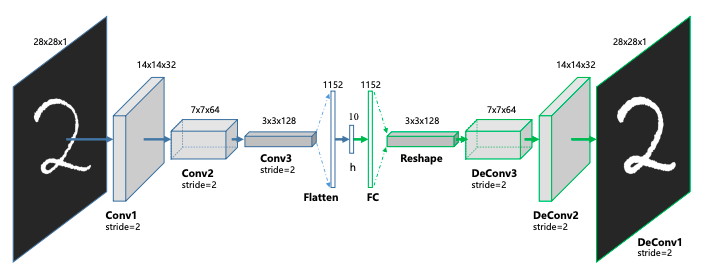
</blockquote>

## 1.2 Dataset

Pour la suite de ce WS, on utilisera une fois de plus **MNIST**, mais cette fois, on va charger l'ensemble de données d'entraînement et de test à partir de Keras, avec la méthode `load_data` de `datasets.mnist`. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

data_dir = pathlib.Path("Photos_autoencodeur")
image_size = 200
batch_s = 10

# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,
    subset ="training",
    seed=42,
    image_size=(image_size, image_size),
    batch_size=batch_s,
    color_mode = 'rgb'
#   label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.05,
    subset ="validation",
    seed=42,
    image_size=(image_size, image_size),
    batch_size=batch_s,
    color_mode = 'rgb'
#   label_mode = "binary"
)


Found 10000 files belonging to 1 classes.
Using 2000 files for training.
Found 10000 files belonging to 1 classes.
Using 500 files for validation.


In [2]:
# Data pre-processing 
x_train = np.concatenate([x for x, y in train_set], axis=0).astype('float32')/255
print(x_train.shape)

x_test = np.concatenate([x for x, y in test_set], axis=0).astype('float32')/255
print(x_test.shape)

x_train = np.reshape(x_train, (len(x_train), image_size, image_size, 3))
x_test = np.reshape(x_test, (len(x_test), image_size, image_size, 3))

(2000, 200, 200, 3)
(500, 200, 200, 3)


Commençons par écrire une fonction qui permet de visualiser $n$ premiers enregistrements en noir et blanc. 

## 1.3 Auto-encodeur de réduction de bruit (denoiser)

Le bruit dans une image est généralement assez visible à l'œil nu et peut être très gênant. Avec un auto-encodeur, il est possible de supprimer les grains de bruit des images afin de voir clairement les principaux objets ou pour un pre-processing avant d'appliquer un auto-encodeur de classification par exemple.
Pour cela, il faut créer un modèle d'auto-encodeur convolutif composé de :
* encodeur composé de trois couches convolutives
* décodeur composé de l'inverse des couches de l'encodeur. 

Quelles sont les données d'entrée et de sortie de l'auto-encodeur ?
<em>À COMPLÉTER</em>


Etant donné que le dataset ne contient pas d'images bruitées, nous allons générer un bruit aléatoire gaussian sur les images. Plus précisément, on va générer un bruit aléatoire *x_train_noisy* et *x_test_noisy* à partir de *x_train* et *x_test*

*Tip* : utiliser la méthode *normal* de *np.random*

In [3]:
import matplotlib.pyplot as plt

def display_image(X, n):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [4]:
noise_factor = 0.4
mean = 0

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0, scale=1, size= x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0, scale=1, size= x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualisez les images d'origines puis les images bruitées.

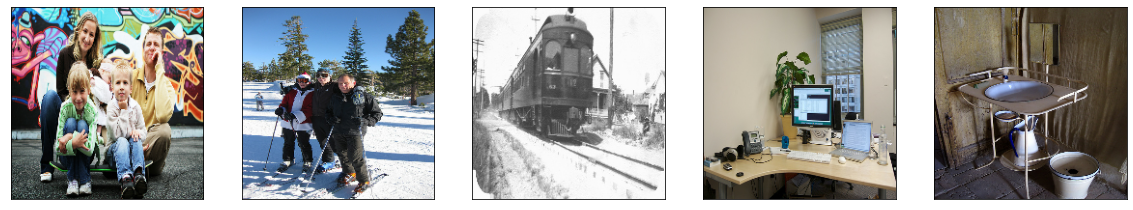

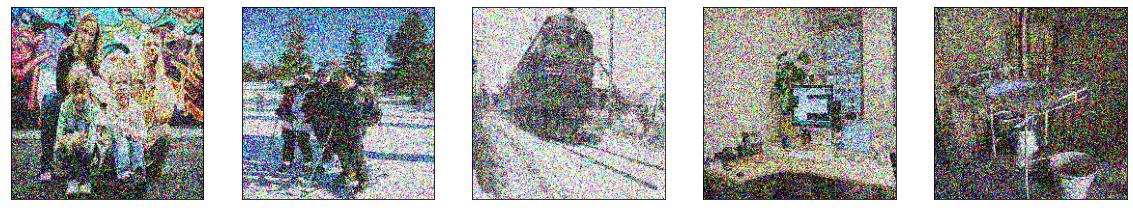

In [5]:
display_image(x_train, n=5)
display_image(x_train_noisy, n=5)


In [18]:
# Configurations principales de nos modèles
NB_EPOCHS_DENOISE = 50               # nombre epoch alogithme debruiter
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

###### Encodeur

Il faut maintenant écrire un code qui permet d'encoder une image en utilisant trois couches de convolution.

*Tip* : Utiliser la classe Input, Conv2D, MaxPooling2D et UpSampling2D

In [19]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

# The encoding process
input_img = Input(shape=(image_size, image_size, 3)) 

# Encoding #

# Conv1 #
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
# kernel_size: Specifying the height and width of the 2D convolution window.
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
# Conv 2 #
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# # Conv 3 #
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoded.shape

# Note:
# padding is a hyper-arameter for either 'valid' or 'same'. 
# "valid" means "no padding". 
# "same" results in padding the input such that the output has the same length as the original input.

TensorShape([None, 50, 50, 64])

###### Décodeur

Passon au décodeur. Écrivez un code qui permet de décoder une image encodée selon l'architecture du réseau de neurones décrite auparavent. 

In [20]:
# Decoding #

# # DeConv1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)

# # Deconv3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv4
# Un autoencoder utilise la fonction sigmoid comme fonction d'activation
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded.shape

TensorShape([None, 200, 200, 3])

In [21]:
from tensorflow.keras.models import Model
# Declare the model
autoencoder = Model(input_img, decoded)

# Pour les autoencoders la fonction de cout peut être soit binary_crossentropy soit rmse
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 128)     512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        3692

In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
# Train the model

history = autoencoder.fit( x_train_noisy, x_train,
                epochs=NB_EPOCHS_DENOISE,
                batch_size=batch_s,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),  
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
            )

Epoch 1/50
200/200 [==============================] - 18s 84ms/step - loss: 0.5441 - val_loss: 0.6387
Epoch 2/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5331 - val_loss: 0.5622
Epoch 3/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5317 - val_loss: 0.5373
Epoch 4/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5296 - val_loss: 0.5396
Epoch 5/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5300 - val_loss: 0.5269
Epoch 6/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5280 - val_loss: 0.5248
Epoch 7/50
200/200 [==============================] - 17s 83ms/step - loss: 0.5270 - val_loss: 0.5287
Epoch 8/50
200/200 [==============================] - 16s 82ms/step - loss: 0.5276 - val_loss: 0.5254
Epoch 9/50
200/200 [==============================] - 17s 83ms/step - loss: 0.5266 - val_loss: 0.5266
Epoch 10/50
200/200 [==============================] - 17s 83ms/step - loss: 0.526

Affichez maintenant la courbe d'apprentissage. Que pensez-vous des performances du modèle ?

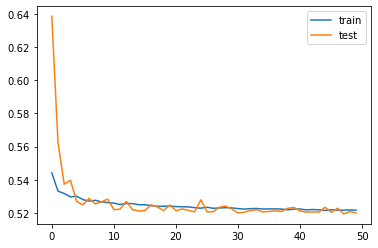

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Que pensez-vous des performances du modèle ?
<em>À COMPLÉTER</em>


# 1.4 Sauvgarde de l'auto-encodeur

L'entrainement de l'auto-encodeur sans utilisation de puissance de calcul (GPU) peut prendre beaucoup de temps. Usuellement, nous sauvegardons le modèle entraîné en local ou sur un serveur distant pour l'utiliser ultérieurement afin de traiter les nouvelles données (d'ailleurs, vous verrez une utilisation avancée de cette technique, le transfert learning, dès la semaine prochaine).
Pour sauvegarder le modèle `autoencoder`, utiliser la méthode `save`.

In [25]:
# save the model
autoencoder.save('saved_model_autoencodeur/my_model')


INFO:tensorflow:Assets written to: saved_model_autoencodeur/my_model\assets


In [26]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_model_autoencodeur/my_model')

In [27]:
import matplotlib.pyplot as plt

def display_image(X, n):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 128)     512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        3692

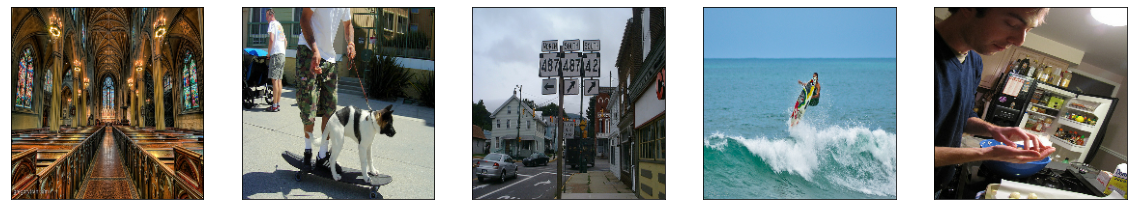

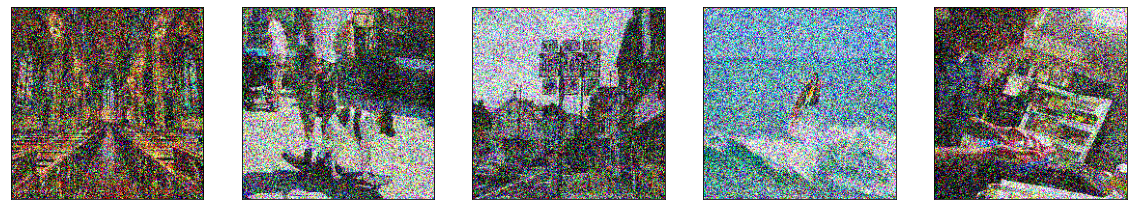

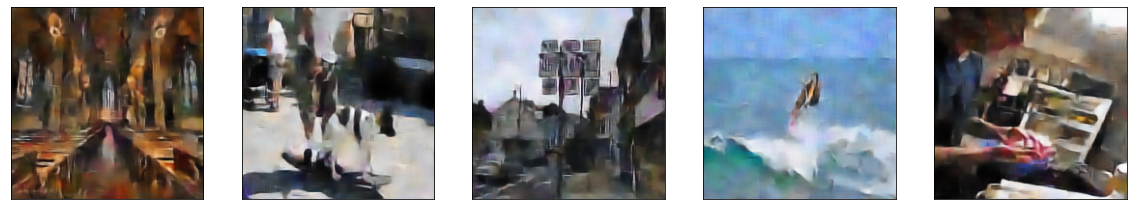

In [28]:
loaded_model.summary()

display_image(x_test, n=5)
display_image(x_test_noisy, n=5)
predictions = loaded_model.predict(x_test_noisy)

predictions = np.reshape(predictions, (len(predictions), image_size, image_size, 3))

display_image(predictions, n=5)
